# Florida Panthers - Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 8, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard features used by the StellarAlgo retention model.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 93 # panthers

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrNHLPanthers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(16334, 54)

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [4]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "source_tenure",
    "totalSpent",
    "year"
]

# select 90% of the data for training
df_train = df.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df.drop(df_train.index).reset_index(drop=True)

# choose features for each train dataset
df_train = df_train[features]

# choose features for each train dataset
df_eval = df_eval[features]

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (13067, 13)
Unseen Data For Predictions: (3267, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [5]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's add one extra model not included in the default pycaret algorithms (ngboost), then we can execute each model and see the performance metrics:

In [6]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    exclude=["lda","qda"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7414,0.8174,0.7814,0.7301,0.7548,0.4819,0.4834,0.6180
xgboost,Extreme Gradient Boosting,0.7378,0.8143,0.7662,0.7317,0.7484,0.4749,0.4757,0.3680
rf,Random Forest Classifier,0.7262,0.7956,0.7589,0.7193,0.7384,0.4516,0.4526,0.1940
gbc,Gradient Boosting Classifier,0.7208,0.7941,0.7777,0.7048,0.7393,0.4404,0.4431,0.1070
et,Extra Trees Classifier,0.7016,0.7682,0.7345,0.6965,0.7149,0.4024,0.4031,0.1770
ada,Ada Boost Classifier,0.6953,0.7663,0.7570,0.6807,0.7167,0.3891,0.3920,0.0430
dt,Decision Tree Classifier,0.6515,0.6515,0.6595,0.6578,0.6583,0.3027,0.3030,0.0110
ridge,Ridge Classifier,0.6459,0.0000,0.6317,0.6590,0.6449,0.2922,0.2926,0.0060
knn,K Neighbors Classifier,0.6237,0.6663,0.6550,0.6248,0.6395,0.2465,0.2469,0.0320
nb,Naive Bayes,0.5995,0.6917,0.3425,0.7264,0.4644,0.2069,0.2443,0.0060


[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5984 val_loss=0.0000 scale=2.0000 norm=3.7591
[iter 200] loss=0.5748 val_loss=0.0000 scale=2.0000 norm=3.7556
[iter 300] loss=0.5632 val_loss=0.0000 scale=2.0000 norm=3.7604
[iter 400] loss=0.5550 val_loss=0.0000 scale=1.0000 norm=1.8806


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5974 val_loss=0.0000 scale=2.0000 norm=3.7552
[iter 200] loss=0.5727 val_loss=0.0000 scale=2.0000 norm=3.7501
[iter 300] loss=0.5598 val_loss=0.0000 scale=2.0000 norm=3.7518
[iter 400] loss=0.5522 val_loss=0.0000 scale=1.0000 norm=1.8779


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5949 val_loss=0.0000 scale=2.0000 norm=3.7435
[iter 200] loss=0.5727 val_loss=0.0000 scale=2.0000 norm=3.7518
[iter 300] loss=0.5638 val_loss=0.0000 scale=1.0000 norm=1.8816
[iter 400] loss=0.5573 val_loss=0.0000 scale=1.0000 norm=1.8833


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)


[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5982 val_loss=0.0000 scale=2.0000 norm=3.7598
[iter 200] loss=0.5754 val_loss=0.0000 scale=2.0000 norm=3.7603
[iter 300] loss=0.5626 val_loss=0.0000 scale=1.0000 norm=1.8798
[iter 400] loss=0.5551 val_loss=0.0000 scale=1.0000 norm=1.8805


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5954 val_loss=0.0000 scale=2.0000 norm=3.7503
[iter 200] loss=0.5706 val_loss=0.0000 scale=2.0000 norm=3.7506
[iter 300] loss=0.5576 val_loss=0.0000 scale=2.0000 norm=3.7534
[iter 400] loss=0.5509 val_loss=0.0000 scale=2.0000 norm=3.7585


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-package

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5978 val_loss=0.0000 scale=2.0000 norm=3.7562
[iter 200] loss=0.5752 val_loss=0.0000 scale=2.0000 norm=3.7598
[iter 300] loss=0.5627 val_loss=0.0000 scale=1.0000 norm=1.8802
[iter 400] loss=0.5554 val_loss=0.0000 scale=2.0000 norm=3.7637


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5986 val_loss=0.0000 scale=2.0000 norm=3.7535
[iter 200] loss=0.5758 val_loss=0.0000 scale=2.0000 norm=3.7537
[iter 300] loss=0.5648 val_loss=0.0000 scale=2.0000 norm=3.7543
[iter 400] loss=0.5591 val_loss=0.0000 scale=2.0000 norm=3.7581
[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5940 val_loss=0.0000 scale=2.0000 norm=3.7442
[iter 200] loss=0.5714 val_loss=0.0000 scale=2.0000 norm=3.7507
[iter 300] loss=0.5596 val_loss=0.0000 scale=1.0000 norm=1.8770
[iter 400] loss=0.5531 val_loss=0.0000 scale=1.0000 norm=1.8798


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5965 val_loss=0.0000 scale=2.0000 norm=3.7529
[iter 200] loss=0.5731 val_loss=0.0000 scale=2.0000 norm=3.7542
[iter 300] loss=0.5616 val_loss=0.0000 scale=2.0000 norm=3.7588
[iter 400] loss=0.5538 val_loss=0.0000 scale=1.0000 norm=1.8803


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

[iter 0] loss=0.6930 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.5960 val_loss=0.0000 scale=2.0000 norm=3.7482
[iter 200] loss=0.5730 val_loss=0.0000 scale=2.0000 norm=3.7488
[iter 300] loss=0.5599 val_loss=0.0000 scale=2.0000 norm=3.7552
[iter 400] loss=0.5542 val_loss=0.0000 scale=1.0000 norm=1.8816


/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-

### The top model is performing well, so let's compare it against our unseen evaluation dataset:

In [7]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7553,0.8294,0.7936,0.7434,0.7677,0.5097,0.5109
1,0.7447,0.8175,0.7824,0.7342,0.7575,0.4886,0.4897
2,0.7218,0.8206,0.7861,0.7030,0.7422,0.4421,0.4454
3,0.7445,0.8207,0.8030,0.7254,0.7622,0.4877,0.4906
4,0.7416,0.8141,0.7692,0.7361,0.7523,0.4826,0.4831
5,0.7522,0.8196,0.8083,0.7325,0.7685,0.5032,0.5060
6,0.7273,0.8076,0.7613,0.7194,0.7397,0.4538,0.4546
7,0.7273,0.7961,0.7406,0.7283,0.7344,0.4542,0.4543
8,0.7589,0.8356,0.8008,0.7448,0.7717,0.5169,0.5184
9,0.7407,0.8129,0.7688,0.7343,0.7511,0.4807,0.4813


### Let's plot the features to see what attributes were the most important to an accurate prediction

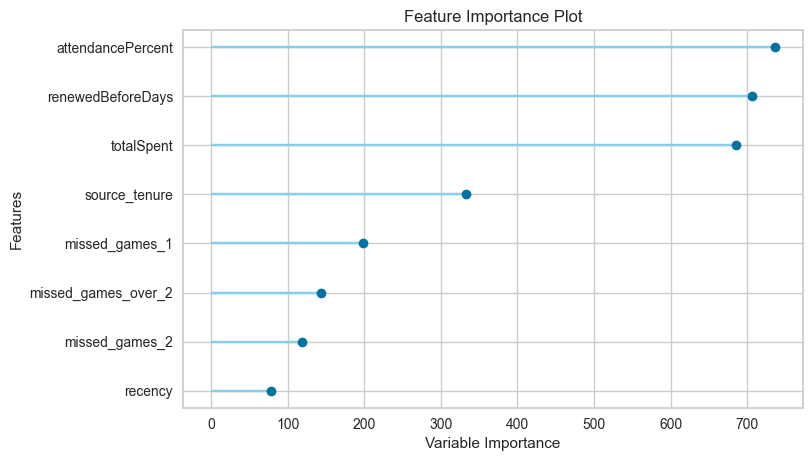

In [8]:
plot_model(best_model, plot='feature')

### Let's also plot a confusion matrix to understand the spread of our predictions

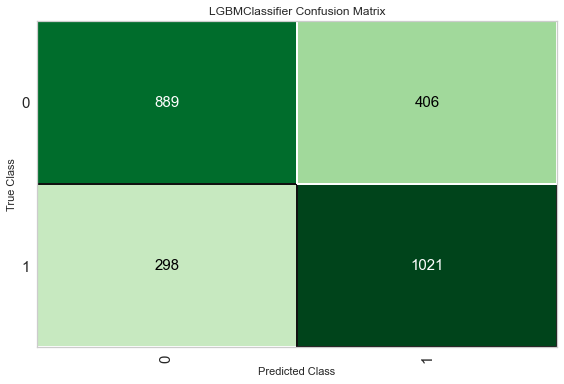

In [9]:
plot_model(best_model, plot='confusion_matrix')

## Observations
* There was a slight decline in accuracy by using the standard features (0.7665 to 0.7635).
* Compared to the extended retention features, the standard StellarAlgo features predicted less overall buyers.
* Compared to the extended retention features, the standard StellarAlgo features did a better job of idenfying buyers who would not rebuy.

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?